In [1]:
import pinecone
import os

PINECONE_API_KEY = "bf349a22-3a4e-487a-a05a-14f9193ed5e6"
PINECONE_ENV_KEY = "asia-southeast1-gcp-free"

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENV_KEY
)

c:\Users\86183\anaconda3\lib\site-packages\pinecone\index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
from collections import Counter

random_state = 42
np.random.seed(random_state)

sample_size = 50000
dim = 10
A_mean = 0.
B_mean = 2.

A_vectors = A_mean + np.random.randn(sample_size, dim)
B_vectors = B_mean + np.random.randn(sample_size, dim)

query_size = 20
A_queries = A_mean + np.random.randn(query_size, dim)

A_vectors.shape, A_queries.shape

((50000, 10), (20, 10))

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

pink = (206 / 255, 0 / 255, 65 / 255)
blue = (0 / 255, 0 / 255, 163 / 255)
green = (24 / 255, 187 / 255, 169 / 255)

plot_df = pd.concat([
    pd.DataFrame(dict(D1=A_vectors[:, 0], D2=A_vectors[:, 1], cluster="A")),
    pd.DataFrame(dict(D1=B_vectors[:, 0], D2=B_vectors[:, 1], cluster="B")),
    pd.DataFrame(dict(D1=A_queries[:, 0], D2=A_queries[:, 1], cluster="Queries"))
])

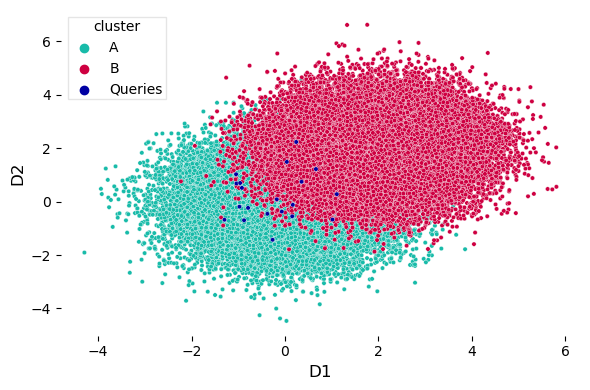

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.tick_params(labelsize=10)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)

sns.scatterplot(
    data=plot_df,
    x="D1",
    y="D2",
    hue="cluster",
    palette=[green, pink, blue],
    s=10,
    ax=ax
)

ax.legend(
    title="cluster",
    loc="upper left",
    borderpad=0.2,
    fancybox=False,
    framealpha=0.5
)

plt.tight_layout()
plt.box(on=None)
plt.show()

In [5]:
index_name = "simple-knn-classifier"

In [6]:
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

pinecone.create_index(
    name=index_name,
    dimension=dim,
    metric="euclidean"
)

In [7]:
index = pinecone.Index(
    index_name=index_name
)

In [8]:
items_df = pd.DataFrame()
items_df["id"] = [f"A-{ii}" for ii in range(len(A_vectors))] + \
    [f"B-{ii}" for ii in range(len(B_vectors))]
items_df["vector"] = [*A_vectors.tolist(), *B_vectors.tolist()]
items_df.sample(5)

,id,vector
73821,B-23821,"[2.623966208755053, 2.8357169758368874, 1.8764..."
40794,A-40794,"[-2.6904050610419135, 0.8447408834928088, 1.24..."
37603,A-37603,"[0.9880934950731799, -1.6256100000890885, 1.16..."
44004,A-44004,"[1.0432248649530014, -0.36081376745290833, -0...."
74962,B-24962,"[0.270605995060029, 1.9475025542153281, 2.3706..."


In [9]:
import itertools


def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))


for vectors in chunks(((row["id"], row["vector"]) for _, row in items_df.iterrows())):
    index.upsert(vectors=vectors)

In [10]:
index.describe_index_stats()

{'dimension': 10,
 'index_fullness': 0.1,
 'namespaces': {'': {'vector_count': 100000}},
 'total_vector_count': 100000}

In [11]:
for result in index.query(
    queries=A_queries.tolist(),
    top_k=10
).results:
    cc = Counter(match.id.split("-")[0] for match in result.matches)
    print(f"Count nearest neighbors' class labels: A={cc['A']}, B={cc['B']}")

Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0


In [12]:
pinecone.delete_index(index_name)